Training Data Score: 0.9460467870891324
Testing Data Score: 0.94670456564221
Accuracy: 0.94670456564221
Training Score: 0.9995854308557892
Testing Score: 0.9543435779001599
[0.01378144 0.01498922 0.0336141  0.03233948 0.013136   0.21059014
 0.19084832 0.01494185 0.01489661 0.03288984 0.03294755 0.01319106
 0.18989955 0.19193482]


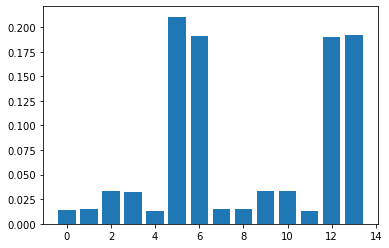

c:\Users\fenwa\anaconda3\envs\PythonData\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
c:\Users\fenwa\anaconda3\envs\PythonData\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


ConnectionError: HTTPSConnectionPool(host='statsapi.web.nhl.com', port=443): Max retries exceeded with url: /api/v1/teams/6/?expand=team.stats (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000026BEEFE8A48>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))

In [1]:
import pandas as pd
import requests
from sklearn.preprocessing import MinMaxScaler
#import pickle?

In [ ]:
#call id from the button click
#plug each id into url, splitting home into a home df and away into an away df
#plug those dfs into model
#return results

In [5]:
def pull_all():
    X = pd.read_csv('Resources/X.csv', index_col=1)
    team_info_df = pd.read_csv('resources/team_info.csv', index_col=1)
    team_info_df['teamName'] = team_info_df['shortName'] + " " + team_info_df['teamName']
    url = "https://statsapi.web.nhl.com/api/v1/teams"
    def pull_home():
        home = userinput left
        home_id = team_info_df[team_info_df['teamName'] == 'f{home}']
        home_id = home_id['team_id'].astype("string")
        home_url = f"{url}/{home_id}/?expand=team.stats"
        home_json = requests.get(home_url).json()
        homedata = []
        id = home_json['teams'][0]['teamStats'][0]['splits'][0]['team']['id']
        name = home_json['teams'][0]['teamStats'][0]['splits'][0]['team']['name']
        pppctg = home_json['teams'][0]['teamStats'][0]['splits'][0]['stat']['powerPlayPercentage']
        pkpctg = home_json['teams'][0]['teamStats'][0]['splits'][0]['stat']['penaltyKillPercentage']
        shots = home_json['teams'][0]['teamStats'][0]['splits'][0]['stat']['shotsPerGame']
        shotsallowed = home_json['teams'][0]['teamStats'][0]['splits'][0]['stat']['shotsAllowed']
        faceoffpctg = home_json['teams'][0]['teamStats'][0]['splits'][0]['stat']['faceOffWinPercentage']
        shootingpctg = home_json['teams'][0]['teamStats'][0]['splits'][0]['stat']['shootingPctg']
        savepctg = home_json['teams'][0]['teamStats'][0]['splits'][0]['stat']['savePctg']
        homedata.append({"id" : id,
                "name_home" : name,
                "pppctg_home" : float(pppctg)/100,
                "pkpctg_home" : float(pkpctg)/100,
                "shots_home" : shots,
                "shotsallowed_home" : shotsallowed,
                "faceoffpctg_home" : faceoffpctg,
                "shootingpctg_home" : float(shootingpctg)/100,
                "savepctg_home" : savepctg})
        home_df = pd.DataFrame(homedata)
        return home_df
    home_df = pull_home
    def pull_away():
        away = userinput right
        away_id = team_info_df[team_info_df['teamName'] == "f{away}"]
        away_id = away_id['team_id'].astype("string")
        away_url = f"{url}/{away_id}/?expand=team.stats"
        away_json = requests.get(away_url).json()
        awaydata = []
        id = away_json['teams'][0]['teamStats'][0]['splits'][0]['team']['id']
        name = away_json['teams'][0]['teamStats'][0]['splits'][0]['team']['name']
        pppctg = away_json['teams'][0]['teamStats'][0]['splits'][0]['stat']['powerPlayPercentage']
        pkpctg = away_json['teams'][0]['teamStats'][0]['splits'][0]['stat']['penaltyKillPercentage']
        shots = away_json['teams'][0]['teamStats'][0]['splits'][0]['stat']['shotsPerGame']
        shotsallowed = away_json['teams'][0]['teamStats'][0]['splits'][0]['stat']['shotsAllowed']
        faceoffpctg = away_json['teams'][0]['teamStats'][0]['splits'][0]['stat']['faceOffWinPercentage']
        shootingpctg = away_json['teams'][0]['teamStats'][0]['splits'][0]['stat']['shootingPctg']
        savepctg = away_json['teams'][0]['teamStats'][0]['splits'][0]['stat']['savePctg']
        awaydata.append({"id" : id,
                "name_away" : name,
                "pppctg_away" : float(pppctg)/100,
                "pkpctg_away" : float(pkpctg)/100,
                "shots_away" : shots,
                "shotsallowed_away" : shotsallowed,
                "faceoffpctg_away" : faceoffpctg,
                "shootingpctg_away" : float(shootingpctg)/100,
                "savepctg_away" : savepctg})
        away_df = pd.DataFrame(awaydata)
        return away_df
    away_df = pull_away
    compiled_stats_df = pd.concat([home_df,away_df],axis=1)
    scaler = MinMaxScaler().fit(X)
    compiled_scaled_df = pd.DataFrame(scaler.transform(compiled_stats_df),columns = compiled_stats_df.columns)
    #import the pickle file from mongo?
    #plug combined_scaled_df into the pickle
    #save results as an object(string? just returning the name of the winner)
    return home_df, away_df, results

,team_id,shortName,teamName,abbreviation,link
franchiseId,,,,,
23,1,New Jersey,New Jersey Devils,NJD,/api/v1/teams/1
16,4,Philadelphia,Philadelphia Flyers,PHI,/api/v1/teams/4
14,26,Los Angeles,Los Angeles Kings,LAK,/api/v1/teams/26
31,14,Tampa Bay,Tampa Bay Lightning,TBL,/api/v1/teams/14
6,6,Boston,Boston Bruins,BOS,/api/v1/teams/6
10,3,NY Rangers,NY Rangers Rangers,NYR,/api/v1/teams/3
17,5,Pittsburgh,Pittsburgh Penguins,PIT,/api/v1/teams/5
12,17,Detroit,Detroit Red Wings,DET,/api/v1/teams/17
29,28,San Jose,San Jose Sharks,SJS,/api/v1/teams/28
